# DRIFT EXAMPLE



Agenda:


*   Data and Concept Drift
*   Import dataset
*   Drift detection:
    1.   Kolmogorov-Smirnov (K-S) test
    2.  Population Stability Index
    3.  Model-Based Approach
    4.  Specialized drift detection techniques: 
  
        4.1.   Adaptive Windowing (ADWIN)

        4.2.   Page-Hinkley method

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -U scikit-multiflow
!pip install river

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Data and Concept Drift

### 1. Data Drift (Covariate) 
Data drift, also known as covariate shift, is the change in the distribution of one or more of the independent variables or input variables of the dataset. This means that even though the relationship between feature and target variable remains unchanged, the distribution of the feature itself has changed. When statistical properties of this input data change, the same model which has been built before will not provide unbiased results. This leads to inaccurate predictions.

*Example*:
Suppose a model is trained with a salary variable that ranges from 200 euro to 300 euro and is in production. Over time, salary increases and the model encounters real-time data with higher salary figures of 1000 euro,1200 euro, and so on. And the model will see an increase in mean and variance, and therefore it leads to a data drift.

###2. Concept Drift
Concept drift is a phenomenon that occurs when the statistical properties of the target variable, which the model is trying to predict, change over time. This means that the relationship between the input variables and the output variable of the data changes, and the predictions become less accurate and become unreliable. One of the main reasons for concept drift to occur is the non-stationarity of data, which refers to the change in statistical properties of data with time.

*Example*:
An example of concept drift can be seen in the abrupt changes in consumer behavior brought on by COVID-19. These changes had a major impact on the accuracy of forecasting models that rely on historical data to inform their predictions. Due to the sudden and drastic change in consumer behavior, the statistical properties of the target variable, which in this case is consumer demand, changed rapidly. As a result, the predictions made by the models became less accurate and unreliable.

## Import dataset

Let's import the dataset. The Churn Modelling dataset contains 14 colums, both numerical and categorical, and 48 rows.


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
#df=pd.read_csv('/content/drive/MyDrive/EY/Churn_Modelling.csv') #from google drive

url = 'https://raw.githubusercontent.com/giuliacrespi/g/main/Churn_Modelling.csv' #from github
df = pd.read_csv(url)

df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602.0,Hargrave,619.0,France,Female,42.0,2.0,0.00,1.0,1.0,1.0,101348.88,1.0
1,2,15647311.0,Hill,608.0,Spain,Female,41.0,1.0,83807.86,1.0,0.0,1.0,112542.58,0.0
2,3,15619304.0,Onio,502.0,France,Female,42.0,8.0,159660.80,3.0,1.0,0.0,113931.57,1.0
3,4,15701354.0,Boni,699.0,France,Female,39.0,1.0,0.00,2.0,0.0,0.0,93826.63,0.0
4,5,15737888.0,Mitchell,850.0,Spain,Female,43.0,2.0,125510.82,1.0,1.0,1.0,79084.10,0.0


For our analysis we will consider only the numerical data.

In [ ]:
df.drop(['RowNumber','CustomerId','Surname'],axis=1,inplace=True)
df_numerical=df.iloc[:,[3,4,5,9]]
df_numerical.head()

,Age,Tenure,Balance,EstimatedSalary
0,42.0,2.0,0.00,101348.88
1,41.0,1.0,83807.86,112542.58
2,42.0,8.0,159660.80,113931.57
3,39.0,1.0,0.00,93826.63
4,43.0,2.0,125510.82,79084.10


Let's split the data into two groups to analyze the difference in both the datasets. The 2 subdataset are divided between people with high and low estimated salary. 


In [ ]:
df_salary_low=df_numerical[df_numerical['EstimatedSalary']<=10000] 
df_salary_high=df_numerical[df_numerical['EstimatedSalary']>10000]
df_salary_low
#df_salary_high

,Age,Tenure,Balance,EstimatedSalary
16,58.0,1.0,132602.88,5097.67
23,46.0,3.0,0.00,8487.75


In [ ]:
print("Salary Low")
print(df_salary_low[["Age", "EstimatedSalary"]].describe())
print("Salary High")
print(df_salary_high[["Age", "EstimatedSalary"]].describe())

Salary Low
             Age  EstimatedSalary
count   2.000000         2.000000
mean   52.000000      6792.710000
std     8.485281      2397.148557
min    46.000000      5097.670000
25%    49.000000      5945.190000
50%    52.000000      6792.710000
75%    55.000000      7640.230000
max    58.000000      8487.750000
Salary High
             Age  EstimatedSalary
count  45.000000        45.000000
mean   37.955556    104895.230667
std     8.956855     51171.079900
min    24.000000     10062.800000
25%    31.000000     70154.220000
50%    39.000000    101348.880000
75%    43.000000    142033.070000
max    61.000000    194365.760000


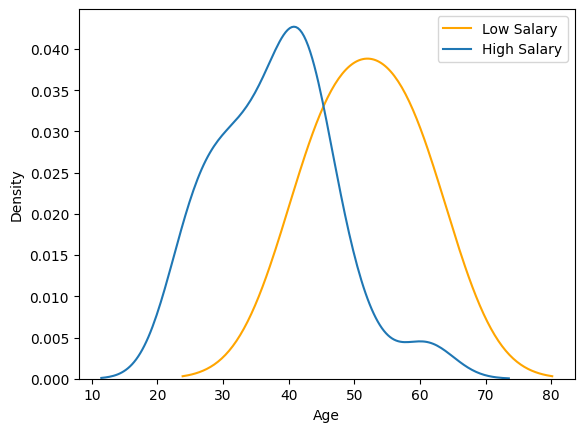

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

a1, a2 = df_salary_low["Age"], df_salary_high["Age"]

ax = plt.axes()
sns.kdeplot(a1, ax=ax, label="Low Salary", color = "orange")
sns.kdeplot(a2, ax=ax, label="High Salary")
ax.xlabel="Age"
ax.legend()
plt.show()

## 1) Kolmogorov-Smirnov (K-S) test:

The K-S test is a nonparametric test that compares the cumulative distributions of two data sets, in this case, the training data and the post-training data. The null hypothesis for this test states that the data distributions from both the datasets are same. If the null is rejected then we can conclude that there is adrift in the model.

In our analysis, we have only considered numerical columns for the test.

For generating our final Data Drift analysis, the chi-squared test can be applied for the categorical features to identify data drift.



In [ ]:
from scipy import stats
p_value = 0.05
rejected = 0
for col in df_numerical.columns:
    test = stats.ks_2samp(df_salary_low[col], df_salary_high[col])
    if test[1] < p_value:
         rejected += 1
         print("Column rejected", col)

print("We rejected",rejected,"columns in total")

Column rejected Age
Column rejected EstimatedSalary
We rejected 2 columns in total


Thus, the K-S test has rejected the Tenure and Estimated Salary columns which means that the statistical properties of these two columns for both the datasets are not identical.

## 2) Population Stability Index:
Population Stability Index (PSI) is a measure used to compare the distribution of the target variable in the test dataset to that of the training dataset used to develop the model. The calculation of PSI involves the following steps:

1. Divide both the expected (test) and actual (training) datasets into buckets based on the minimum and maximum values of the target variable in the training data.

2. Calculate the percentage of observations in each bucket for both datasets.

3. Use the formula to calculate PSI. 

Thresholds are the following:
- PSI<=1 indicates no significant shift in the distributions of both datasets.
- 0.1< PSI <0.2 indicates a slight shift.
- PSI >0.2 indicates a large shift in the distribution of the target variable between the datasets.

Note that PSI can be used to detect data drift in both categorical and numerical variables.

In [ ]:
def calculate_psi(expected, actual, buckettype='bins', buckets=10, axis=0):
    def psi(expected_array, actual_array, buckets):
        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input
        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100
        breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_percents = np.histogram(actual_array, breakpoints)[0] / len(actual_array)
        def sub_psi(e_perc, a_perc):
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))
        return(psi_value)
 
    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[axis])

    for i in range(0, len(psi_values)):
        psi_values = psi(expected, actual, buckets)
    return(psi_values)


## Calculate psi for features
psi_list = []
top_feature_list=df_salary_high.columns
for feature in top_feature_list:
        # Assuming you have a validation and training set
        psi_t = calculate_psi(df_salary_high[feature], df_salary_low[feature])
        psi_list.append(psi_t)      
        print('Stability index for column ',feature,'is',psi_t)


Stability index for column  Age is 7.015583255748483
Stability index for column  Tenure is 7.321931371248534
Stability index for column  Balance is 2.889080544468804
Stability index for column  EstimatedSalary is 6.952453306969581


<ipython-input-22-71d0692f9166>:23: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))


## 3) Model-Based Approach
Another approach to detect data drift between two populations is by using a machine learning-based model. To implement this, we can label the data used to build the current production model as 0 and label the real-time data as 1. Next, we build a model and evaluate its performance.

If the model exhibits high accuracy, it suggests that it can easily distinguish between the two sets of data. In such a scenario, we can conclude that a covariate shift has occurred and the model needs to be recalibrated. Conversely, if the model accuracy is around 0.5, it means that it is as good as a random guess. This implies that a significant data shift has not occurred and we can continue using the model.

However, this approach has a drawback. Every time new input data becomes available, the training and testing process needs to be repeated, which can be computationally expensive.

## 4.1) Using specialized drift detection techniques such as Adaptive Windowing (ADWIN):

The Adaptive Windowing (ADWIN) algorithm uses a sliding window approach to detect concept drift. Window size is fixed and ADWIN slides the fixed window for detecting any change on the newly arriving data. When two sub-windows show distinct means in the new observations the older sub-window is dropped.

A user-defined threshold is set to trigger a warning that drift is detected. If the absolute difference between the two means derived from two sub-windows exceeds the pre-defined threshold, an alarm is generated. This method is applicable for univariate data.

[trial online](https://www.cs.upc.edu/~abifet/Prova/)

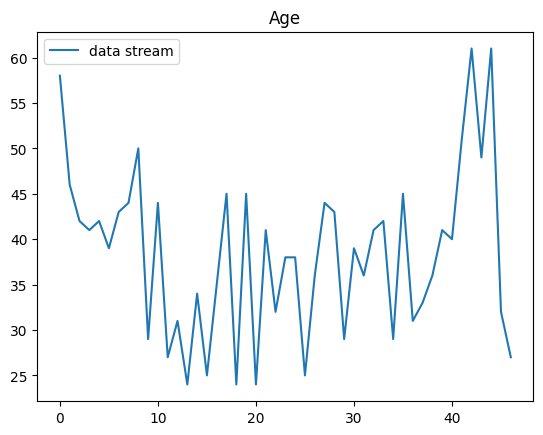

Change detected in data: 7.0 - at index: 16for column:Tenure


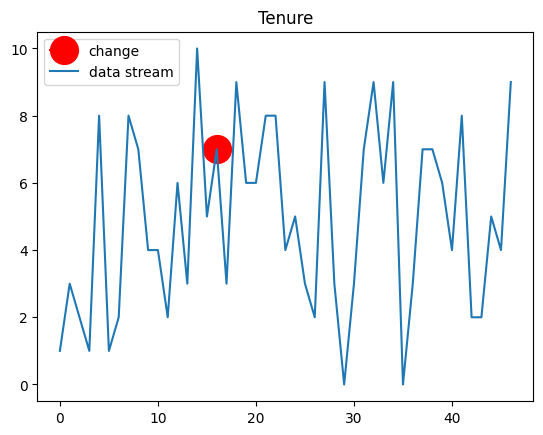

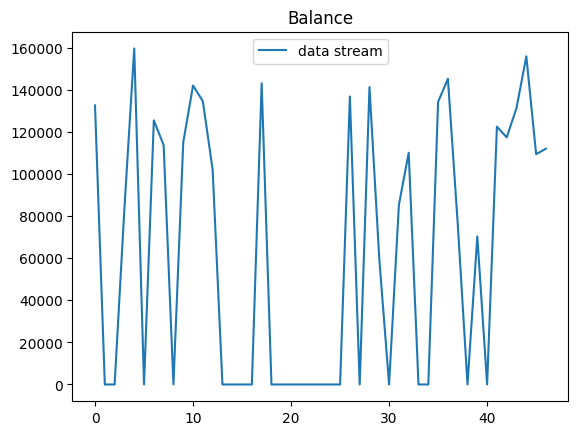

Change detected in data: 14406.41 - at index: 18for column:EstimatedSalary


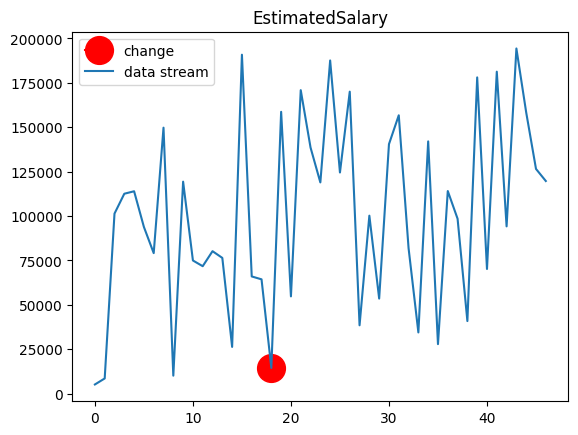

In [ ]:
from skmultiflow.drift_detection import ADWIN

adwin = ADWIN()
for col in df_numerical.columns:
    data_stream=[]
    a = np.array(df_salary_low[col])
    b = np.array(df_salary_high[col])
    data_stream = np.concatenate((a,b))
# Adding stream elements to ADWIN and verifying if drift occurred
    for i in range(len(data_stream)):
        adwin.add_element(data_stream[i])
        if adwin.detected_change():
            print('Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i) +'for column:' + col)
            plt.plot(i, data_stream[i], label = "change", marker="o", markersize=20, color="red")
    plt.plot(data_stream, label = "data stream")
    plt.title(col)
    plt.legend()
    plt.show()

## 4.2) Using specialized drift detection techniques such as Page-Hinkley method:

This change detection method works by computing the observed values and their mean up to the current moment. Page-Hinkley won’t output warning zone warnings, only change detections. The method works by means of the Page-Hinkley test. In general lines it will detect a concept drift if the observed mean at some instant is greater then a threshold value lambda.

This change detection method works by computing the observed values and their mean up to the current moment. Page-Hinkley does not signal warning zones, only change detections.

Change detected at index 29 for column: Age with input value: 29.0


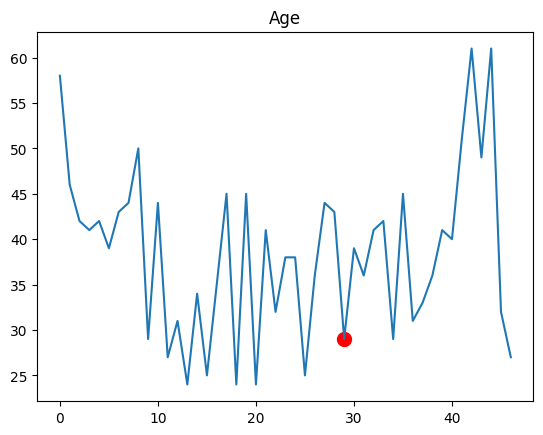

Change detected at index 12 for column: Tenure with input value: 6.0


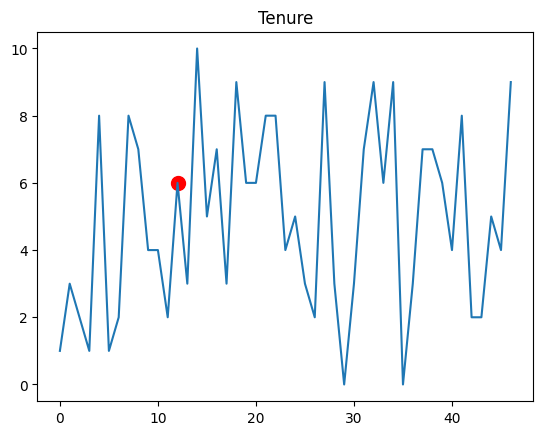

Change detected at index 0 for column: Balance with input value: 132602.88
Change detected at index 30 for column: Balance with input value: 0.0


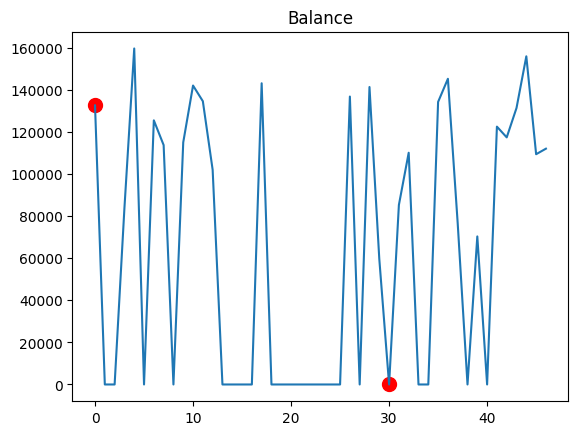

Change detected at index 13 for column: EstimatedSalary with input value: 76390.01
Change detected at index 43 for column: EstimatedSalary with input value: 194365.76


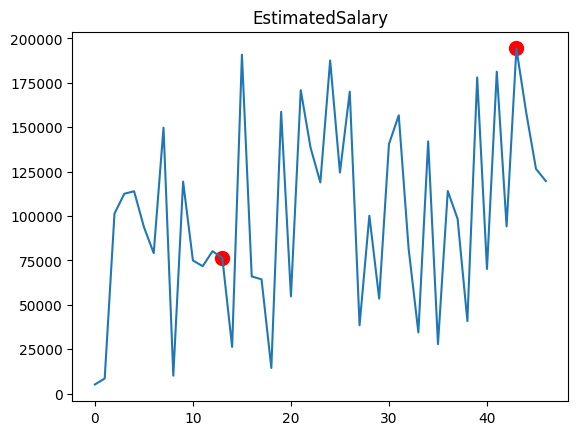

In [ ]:
from river.drift import PageHinkley

np.random.seed(12345)
ph = PageHinkley()
# Update drift detector and verify if change is detected
for col in df_numerical.columns:
    data_stream=[]
    a = np.array(df_salary_low[col])
    b = np.array(df_salary_high[col])
    data_stream = np.concatenate((a,b))
    #m_ds = np.mean(data_stream)
    #data_stream = data_stream/m_ds
    for i, val in enumerate(data_stream):
        _ = ph.update(val)
        if ph.drift_detected:
            print(f"Change detected at index {i} for column: {col} with input value: {val}")
            plt.plot(i, data_stream[i], label = "change", marker="o", markersize=10, color="red")
    plt.plot(data_stream, label = "data stream")
    plt.title(col)
    plt.show()